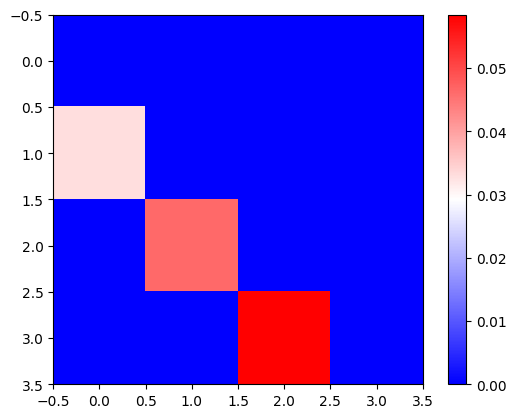

In [1]:
from simulate_data import Simulation
number_of_locations = 4
n = number_of_locations
days = 60

simulation = Simulation(num_locations = n, days = days)
simulation.plot_mov_ratio()

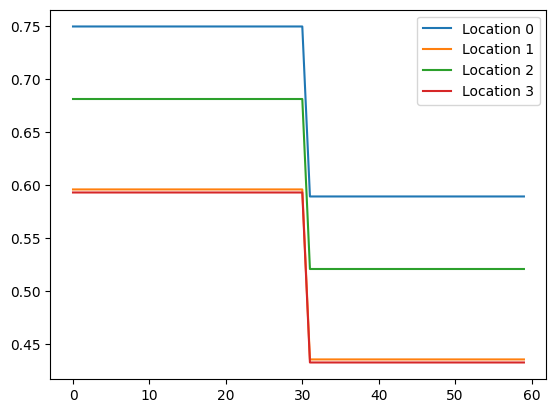

In [2]:
simulation.plot_real_beta()

In [3]:
from tau_leap import SIR_tau_leap
simulation.run_sir_model(SIR_tau_leap)

/home/andrew/Documents/code/multi-node-forecast/tau_leap.py:27: RuntimeWarning: invalid value encountered in divide
  mov_SI = np.divide(np.multiply(mov_I, mov_S), movement)


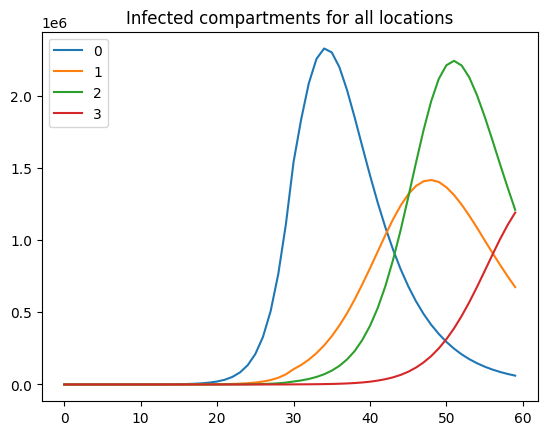

In [4]:
simulation.plot_infected()

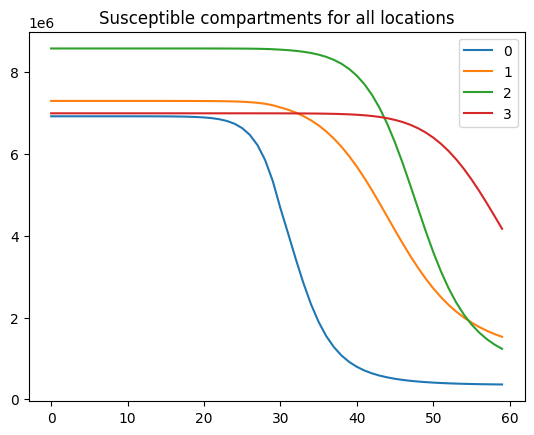

In [5]:
simulation.plot_susceptible()

We will define a new function that runs both filters at the same time. 
Then, we will compare the weights and resampling indices. 

In [6]:
from particle_filter import *

def run_dual_particle_filter(params: ParticleFilterParams) -> (
        ParticleFilterState, ParticleFilterState):
    """
    Runs lin and log domain PFs to make comparisons. 
    
    Args:
        params: A ParticleFilterParams object, applied to both lin and log domain.
        
    Returns:
        (lin_state, log_state): A tuple containing two ParticleFilterStates 
        objects.
    """
    lin_state = initialize_particles(params)
    log_state = initialize_particles(params)

    for t in range(params.results.shape[0]):
        print(f"Iteration: {t + 1}")

        if t != 0:
            update_particles(params, lin_state, t)
            update_particles(params, log_state, t)

        compute_linear_weights(params, lin_state, t)
        lin_state.save_weights()
        compute_log_weights(params, log_state, t)
        log_state.save_weights()
        
        linear_resample_algo(lin_state, t)
        log_resample_algo(log_state, t)
        
        perturb_betas(lin_state, params.num_locations, t)
        perturb_betas(log_state, params.num_locations, t)

        posterior_update(lin_state, t)
        posterior_update(log_state, t)

    return lin_state, log_state